<font size="+2" color="blue"><b>Table of Content</b></font><br>
1.  [ General Advice](#1)
1.  [ Some important study material links related to this project](#2) 
1.  [ References of some other notebooks used in this project](#3)
1.  [ Importing relevant Libraries](#4)
1.  [ Evaluation Metric](#5)
1.  [ Loading & Describing the Dataset](#6)
1.  [ EDA](#7)
       - [7.1 Missing Values Check](#7.1)
       - [7.2 Imbalanced dataset Check](#7.2)
       - [7.3 Is selected_text word count different from original tweet text word count ?](#7.3)
       - [7.4 Are URLs occuring all in all the three types of tweets](#7.4)
       - [7.5 Frequency of stop words in each category of tweets](#7.5)
       - [7.6 Most frequently occuring words in each types of tweets](#7.6)
       
1.  [ Applying RoBERTa Model](#8)      


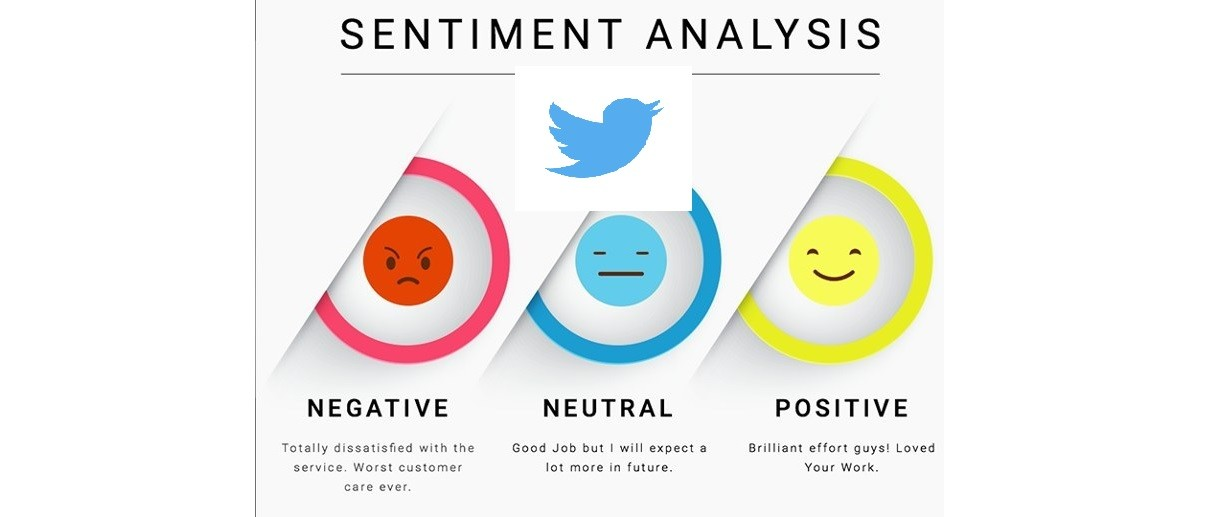

<font size="+2" color="indigo"><b>1. General Advice</b></font><br>

* If you are not familiar with some of the advanced NLP based models like RoBERTa then I would strongly recommend you to first visit the references that I have provided below. After that it would be very easy for you to understand the RoBERTa code that I have written in this notebook.
 
* Ensure that you have enabled GPU accelerator for your notebook at the time of running your notebook for faster performance. You can enable it by clicking on the arrow appearing on the right of "Save Version" button. 


<font size="+2" color="orange"><b>2. Some important study material links related to this project</b></font><br>


Explanation of the architecture of RoBERTa model - https://www.youtube.com/watch?v=6a6L_9USZxg

https://www.kaggle.com/abhishek/roberta-inference-5-folds


<font size="+2" color="green"><b>3. References of some other notebooks used in this project</b></font><br>


1. For EDA - https://www.kaggle.com/raenish/tweet-sentiment-insight-eda , https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15

2. For Word Clouds - https://www.kaggle.com/aashita/word-clouds-of-various-shapes

3. For RoBERTa - https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705 , https://www.kaggle.com/abhishek/roberta-inference-5-folds

4. How to make RoBERTa run 2X faster - https://www.kaggle.com/seesee/faster-2x-tf-roberta


<font size="+2" color="teal"><b>4. Importing relevant Libraries</b></font><br>

In [ ]:
import numpy as np 
import pandas as pd 
import os
import re
import string
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns


from tqdm import tqdm
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
from collections import defaultdict
from collections import  Counter


# sklearn 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
stop=set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#Avoid warning messages
import warnings
warnings.filterwarnings("ignore")

#plotly libraries
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')


import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers

from datetime import datetime as dt
import math

<font size="+2" color="coral"><b>5. Evaluation Metric</b></font><br>

> Jaccard Similarity -  It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations. You can relate it with the concept of substring matching. 

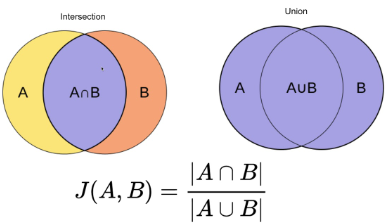

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

Actual_1 = 'Twitter Sentiment Analysis'
Predict_1 = 'Sentiment Analysis'

Actual_2 = 'Twitter Sentiment Analysis'
Predict_2 = 'Analysis'
    
print("Jaccard score for first set of scentences: {}".format(jaccard(Actual_1,Predict_1)))
print("Jaccard score for second set of scentences: {}".format(jaccard(Actual_2,Predict_2)))

<font size="+2" color="maroon"><b>6. Loading & Describing the Dataset</b></font><br>


In [ ]:
ori_train=pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
ori_test=pd.read_csv('../input/tweet-sentiment-extraction/test.csv')

train = ori_train
test = ori_test

ori_train = ori_train.fillna("")
ori_test  = ori_test.fillna("")

train.head(10)

print("There are {} rows and {} columns in train file".format(train.shape[0],train.shape[1]))
print("There are {} rows and {} columns in test file".format(test.shape[0],test.shape[1]))

| Columns       |      Description          | 
|---------------|:-------------------------:|
| ID            |  Unique ID for each tweet |       
| Text          |  Whole content of tweet   |   
| Selected Text |  Selected Text of tweet   |    
| Sentiment     |  Sentiment of tweet       |

<font size="+2" color="red"><b>7. EDA</b></font><br>

> Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

*It is a good practice to understand the data first and try to gather as many insights from it. EDA is all about making sense of data in hand,before getting them dirty with it.*

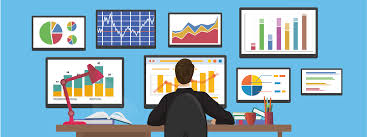

<font size="+2" color="purple"><b>7.1 Missing Values Check</b></font><br>

In [ ]:
print(train.shape[0])
print(train.info())

> ## CONCLUSION : Since only one row values are missing so we will fill "" in place of that.

*What if a large number of rows contain missing values? - In that case we cannot simply delete the missing rows because that will cause loss of data which was present in some other non-missing columns.In this case we would have to think about replacing those missing values with some appropriate values derived after observing the behviour of dataset.*

In [ ]:
train = ori_train
test = ori_test

<font size="+2" color="lime"><b>7.2 Imbalanced dataset Check</b></font><br>

In [ ]:
# count unique values present in each column
def count_values(df,feature):
    total=df.loc[:,feature].value_counts(dropna=False)
    percent=round(df.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percent],axis=1,keys=['Total','Percent'])

In [ ]:
sent_train=count_values(train,'sentiment')
colors = ['orange','green','red']

fig = make_subplots(rows=1, cols=1,specs=[[{"type": "pie"}]])

fig.add_trace(go.Pie(labels=list(sent_train.index), values=list(sent_train.Total.values), hoverinfo='label+percent', 
               textinfo='value+percent',marker=dict(colors=colors)),row=1,col=1)

fig.update_layout( title_text="Positive Vs Negative Vs Neutral Counts",title_x=0.5)
iplot(fig)

> ## CONCLUSION : Neutral tweets are appearing more in the datset followed by positive & negative tweets. Positive & Negative are almost equally probable. But the difference is not that large to classify this as an imbalanced dataset.So we will keep the dataset as it is.

*What if we had imbalanced dataset : We then had to implement techniques like upsampling, creating synthetic points(Data Augmentation),etc. Downsampling majority class is generally not recommended because it results into loss of dataset which ultimately results into loss of information.*

<font size="+2" color="blue"><b>7.3 Is selected_text word count different from original tweet text word count ?</b></font><br>

In [ ]:
sent=train.sentiment.unique()
fig,ax= plt.subplots(1,3,figsize=(12,6))

for i in range(0,3):
    sns.distplot(train[train['sentiment']==sent[i]]['text'].str.split().str.len(), hist=True, kde=True, 
             bins=int(180/5), color = colors[i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax = ax[i])
    ax[i].set_title(sent[i])
    ax[i].grid(False)
fig.suptitle("Distribution of number of No: Words in Tweets", fontsize=14)

sent=train.sentiment.unique()
fig,ax= plt.subplots(1,3,figsize=(12,6))
plt.grid(b=None)
for i in range(0,3):
    sns.distplot(train[train['sentiment']==sent[i]]['selected_text'].str.split().str.len(), hist=True, kde=True, 
             bins=int(180/5), color = colors[i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax = ax[i])
    ax[i].set_title(sent[i])
    ax[i].grid(False)
fig.suptitle("Distribution of number of No: Words in Selected text", fontsize=14)

> ## CONCLUSION : As we can clearly see that the distribution of words counts for text & selected_text for neutral tweets is identical which means that all the text is taken into selected_text for neutral tweets.Whereas there is difference in the words counts distribution plots of positive & negative tweets. 

<font size="+2" color="orange"><b>7.4 Are URLs occuring all in all the three types of tweets</b></font><br>

> ### Function to create hovering effect in a dataframe. Just for fun.

In [ ]:
from IPython.display import HTML

def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

> ### Function to search for presence of URL in a text

In [ ]:
# Find URL
def find_link(string): 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string)
    return "".join(url) 
train['target_url']=train['selected_text'].apply(lambda x: find_link(x))
df2=pd.DataFrame(train.loc[train['target_url']!=""]['sentiment'].value_counts()).reset_index()
df2.rename(columns={"index": "sentiment", "sentiment": "url_count"},inplace = True)

styles = [
    hover(),
    dict(selector="th", props=[("font-size", "150%"),
                               ("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]
html = (df2.style.set_table_styles(styles)
          .set_caption("Hover to highlight."))
html

> ## CONCLUSION : As we can see out of total 351 tweets containing URLs, 345 of them belong to neutral tweets. So it's a clear indication that tweets containing URLs will be mostly a neutral tweet & we can use the URL as a selected_text to justify this sentiment. 

<font size="+2" color="coral"><b>7.5 Frequency of stop words in each category of tweets</b></font><br>

> ### Creating corpus of all the tweet text words in our dataset

In [ ]:
def create_corpus_text(target): 
    corpus=[]
    for x in train[train['sentiment']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

> ### CREATING DICTIONARY FOR TWEET TEXTS

In [ ]:
corpus=create_corpus_text("positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top_0=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]

#################################################

corpus=create_corpus_text("negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top_1=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]


#################################################

corpus=create_corpus_text("neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top_2=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]

> ### Printing stop words for Tweet Texts

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x0,y0=zip(*top_0)
x1,y1=zip(*top_1)
x2,y2=zip(*top_2)
plt.bar(x0,y0, color=['green'], label = "positive")           
plt.bar(x1,y1, color=['red'], label = "negative")              
plt.bar(x2,y2, color=['orange'], label = "neutral")
plt.legend()



> ### Creating corpus of all the selected_text words in our dataset

In [ ]:
def create_corpus_selected_text(target): 
    corpus=[]
    for x in train[train['sentiment']==target]['selected_text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

> ### CREATING DICTIONARY FOR SELECTED_TEXTS

In [ ]:
corpus=create_corpus_selected_text("positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top_0_selected_text=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]

##################################################

corpus=create_corpus_selected_text("negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top_1_selected_text=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]

#################################################

corpus=create_corpus_selected_text("neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top_2_selected_text=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]

> ### Printing stop words for Selected Texts

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x0,y0=zip(*top_0_selected_text)
x1,y1=zip(*top_1_selected_text)
x2,y2=zip(*top_2_selected_text)
plt.bar(x0,y0, color=['green'], label = "positive")           
plt.bar(x1,y1, color=['red'], label = "negative")              
plt.bar(x2,y2, color=['orange'], label = "neutral")
plt.legend()

> ## CONCLUSION : Neutral tweets have most of the stop words in both tweet texts & selected_texts as it clearly visible in the above bar plot. Equally high number of stop word in selected_texts is expected because in case of neutral tweets selected_texts~tweet texts. One more thing to note here is that the selected_text for positive & negative tweets contains only few stop words which is also expected because the selected_texts for + & - tweets contain words describing the sentiments which mostly doesn't belong to any stop words.

<font size="+2" color="navy"><b>7.6 Most frequently occuring words in each types of tweets</b></font><br>

In [ ]:
d = '../input/newwordcloud/'
positive = np.array(Image.open(d + 'positive.jpg'))
negative = np.array(Image.open("../input/negativeimage/negative.jpeg"))
neutral = np.array(Image.open(d + 'neutral.jpg'))
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',mask=positive,colormap="Greens",
                        width=800,
                        height=600).generate(" ".join(train.loc[train['sentiment']=="positive"]['text']))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Tweet Text',fontsize=35);

wordcloud1_selected_text = WordCloud( background_color='white',mask=positive,colormap="Greens",
                        width=800,
                        height=600).generate(" ".join(train.loc[train['sentiment']=="positive"]['selected_text']))
ax4.imshow(wordcloud1_selected_text)
ax4.axis('off')
ax4.set_title('Positive Selected Text',fontsize=35);

wordcloud2 = WordCloud( background_color='white',mask=negative,colormap="Reds",
                        width=800,
                        height=600).generate(" ".join(train.loc[train['sentiment']=="negative"]['text']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Tweet Text',fontsize=35);


wordcloud2_selected_text = WordCloud( background_color='white',mask=negative,colormap="Reds",
                        width=800,
                        height=600).generate(" ".join(train.loc[train['sentiment']=="negative"]['selected_text']))
ax5.imshow(wordcloud2_selected_text)
ax5.axis('off')
ax5.set_title('Negative Selected Text',fontsize=35);

wordcloud3 = WordCloud( background_color='white',mask=neutral,colormap="Oranges",
                        width=800,
                        height=600).generate(" ".join(train.loc[train['sentiment']=="neutral"]['text']))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral Tweet Text',fontsize=35);

wordcloud3_selected_text = WordCloud( background_color='white',mask=neutral,colormap="Oranges",
                        width=800,
                        height=600).generate(" ".join(train.loc[train['sentiment']=="neutral"]['selected_text']))
ax6.imshow(wordcloud3_selected_text)
ax6.axis('off')
ax6.set_title('Neutral Selected Text',fontsize=35);

> ## CONCLUSION : Words like "love", "good" ,"happy" appear in positive tweets whereas negative words like "hate", "miss", "sick" appears in negatvie tweets and general words like "now","going","still" appear in neutral type of tweets. All as expected.
> 
*Why are we drawing Word Clouds : Generally we draw word clouds to have an idea about the most common words appearing in the document(tweets in this case). In reference to this dataset, it also gives an idea about the words people are most commonly using in all the three types of tweets.*

<font size="+2" color="maroon"><b>8 Applying RoBERTa Model</b></font><br>

# *I would highly encourage you to go throught the reference links provided in the starting of this notebook to understand RoBERTa's model architecture, I/O format etc.*

In [ ]:
print('TF version',tf.__version__)

> ## Loading Tokenizer

In [ ]:
MAX_LEN = 96
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
EPOCHS = 3
BATCH_SIZE = 32
PAD_ID = 1
SEED = 88888
LABEL_SMOOTHING = 0.1
tf.random.set_seed(SEED)
np.random.seed(SEED)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = ori_train
train.head()

> ## Training Data

*We will have to convert the input into a way that RoBERTa model understands. Refer to the below example for reference.*

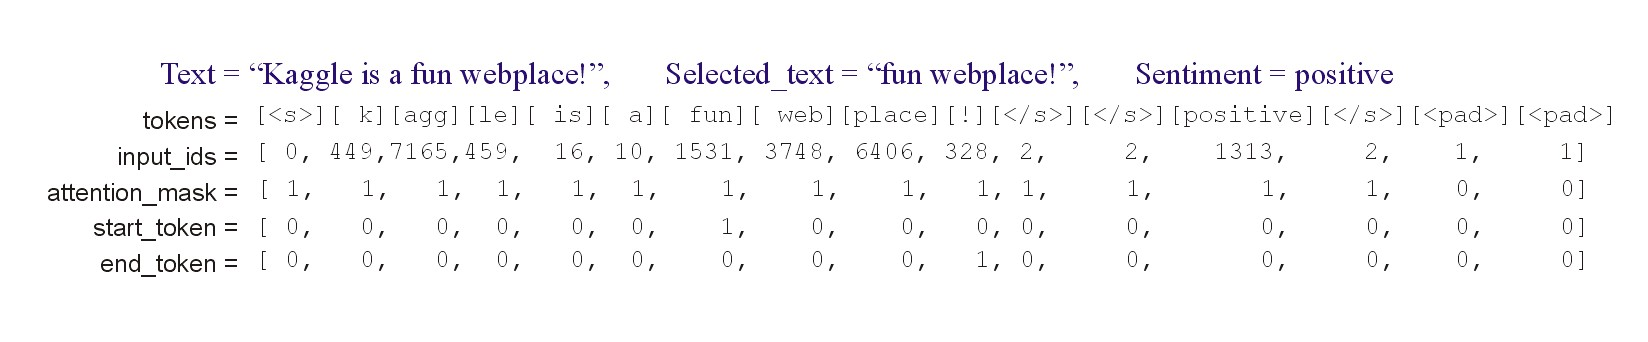

In [ ]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask[k,:len(enc.ids)+3] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+2] = 1
        end_tokens[k,toks[-1]+2] = 1

> ## Tokenizing test data as well

In [ ]:
test = ori_test
ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask_t[k,:len(enc.ids)+3] = 1

> ## Defining the architecuture of RoBERTa model



> ## Functions to save/load model's weights

In [ ]:
import pickle

def save_weights(model, dst_fn):
    weights = model.get_weights()
    with open(dst_fn, 'wb') as f:
        pickle.dump(weights, f)


def load_weights(model, weight_fn):
    with open(weight_fn, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    return model

def loss_fn(y_true, y_pred):
    # adjust the targets for sequence bucketing
    ll = tf.shape(y_pred)[1]
    y_true = y_true[:, :ll]
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred,
        from_logits=False, label_smoothing=LABEL_SMOOTHING)
    loss = tf.reduce_mean(loss)
    return loss

> I have added some layers in addition to what you will see in most of the kernels to check whether this improves model's performance or not. And guess what. It worked.

In [ ]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    padding = tf.cast(tf.equal(ids, PAD_ID), tf.int32)

    lens = MAX_LEN - tf.reduce_sum(padding, -1)
    max_len = tf.reduce_max(lens)
    ids_ = ids[:, :max_len]
    att_ = att[:, :max_len]
    tok_ = tok[:, :max_len]

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids_,attention_mask=att_,token_type_ids=tok_)
    
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2,padding='same')(x1)
    x1 = tf.keras.layers.ReLU()(x1)
    x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(768, 2,padding='same')(x2)
    x2 = tf.keras.layers.ReLU()(x2)
    x2 = tf.keras.layers.Conv1D(64, 2, padding='same')(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)
    
    #x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    #x1 = tf.keras.layers.Conv1D(1,1)(x1)
    #x1 = tf.keras.layers.Flatten()(x1)
    #x1 = tf.keras.layers.Activation('softmax')(x1)
    
    #x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    #x2 = tf.keras.layers.Conv1D(1,1)(x2)
    #x2 = tf.keras.layers.Flatten()(x2)
    #x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss=loss_fn, optimizer=optimizer)
    
    # this is required as `model.predict` needs a fixed size!
    x1_padded = tf.pad(x1, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    x2_padded = tf.pad(x2, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    
    padded_model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1_padded,x2_padded])
    return model, padded_model

> ## Training RoBERTa model

In [ ]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model, padded_model = build_model()
        
    #sv = tf.keras.callbacks.ModelCheckpoint(
    #    '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
    #    save_weights_only=True, mode='auto', save_freq='epoch')
    inpT = [input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]]
    targetT = [start_tokens[idxT,], end_tokens[idxT,]]
    inpV = [input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]]
    targetV = [start_tokens[idxV,], end_tokens[idxV,]]
    # sort the validation data
    shuffleV = np.int32(sorted(range(len(inpV[0])), key=lambda k: (inpV[0][k] == PAD_ID).sum(), reverse=True))
    inpV = [arr[shuffleV] for arr in inpV]
    targetV = [arr[shuffleV] for arr in targetV]
    weight_fn = '%s-roberta-%i.h5'%(VER,fold)
    for epoch in range(1, EPOCHS + 1):
        # sort and shuffle: We add random numbers to not have the same order in each epoch
        shuffleT = np.int32(sorted(range(len(inpT[0])), key=lambda k: (inpT[0][k] == PAD_ID).sum() + np.random.randint(-3, 3), reverse=True))
        # shuffle in batches, otherwise short batches will always come in the beginning of each epoch
        num_batches = math.ceil(len(shuffleT) / BATCH_SIZE)
        batch_inds = np.random.permutation(num_batches)
        shuffleT_ = []
        for batch_ind in batch_inds:
            shuffleT_.append(shuffleT[batch_ind * BATCH_SIZE: (batch_ind + 1) * BATCH_SIZE])
        shuffleT = np.concatenate(shuffleT_)
        # reorder the input data
        inpT = [arr[shuffleT] for arr in inpT]
        targetT = [arr[shuffleT] for arr in targetT]
        model.fit(inpT, targetT, 
            epochs=epoch, initial_epoch=epoch - 1, batch_size=BATCH_SIZE, verbose=DISPLAY, callbacks=[],
            validation_data=(inpV, targetV), shuffle=False)  # don't shuffle in `fit`
        save_weights(model, weight_fn)

    print('Loading model...')
    # model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    load_weights(model, weight_fn)

    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = padded_model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = padded_model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-2:b-1])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

In [ ]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))

> ## How to submit the file

In [ ]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-2:b-1])
    all.append(st)

In [ ]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

# ✔️PLEASE GIVE THIS NOTEBOOK AN UPVOTE IF YOU LIKED IT!!!